In [1]:
#-------------- Python 3.7 ------------------#
# Lets import loadmat required to import .mat files
from scipy.io import loadmat
# Of course we also need signal from Scipy too
from scipy import signal
# Importing numpy to make it possible to perform vector operations
import numpy as np
# These two libraries are for visualization
import matplotlib.pyplot as plt
from pandas import Series
import pandas as pd
import os
from config import *
%matplotlib notebook

def BandPassECG(ECG,Fs):
    '''
    This function takes in a "path" and imports the ECG signal in .mat format
    '''
    # Import the signal
    # Implementing the Butterworth BP filter
    W1     = 2*2/Fs                                    # --> 5 Hz cutt-off (high-pass) and Normalize by Sample Rate
    W2     = 30*2/Fs                                   # --> 15 Hz cutt-off (low-pass) and Normalize by Sample Rate
    b, a   = signal.butter(2, [W1,W2], 'bandpass')     # --> create b,a coefficients , since this is IIR we need both b and a coefficients
    ECG    = np.asarray(ECG)                           # --> let's convert the ECG to a numpy array, this makes it possible to perform vector operations 
    ECG    = np.squeeze(ECG)                           # --> squeeze
    ECG_BP = signal.filtfilt(b,a,ECG)    # --> filtering: note we use a filtfilt that compensates for the delay
    return ECG_BP,ECG

def Differentiate(ECG):
    '''
    Compute single difference of the signal ECG
    '''
    ECG_df  = np.diff(ECG)
    ECG_sq  = np.power(ECG_df,2)
    return np.insert(ECG_sq,0, ECG_sq[0])

def MovingAverage(ECG,N=30):
    '''
    Compute moving average of signal ECG with a rectangular window of N
    '''
    window  = np.ones((1,N))
    ECG_ma  = np.convolve(np.squeeze(ECG),np.squeeze(window))
    return ECG_ma

def QRSpeaks(ECG,Fs):
    '''
    Finds peaks in a smoothed signal ECG and sampling freq Fs.
    '''
    peaks, _  = signal.find_peaks(ECG, height=np.mean(ECG), distance=round(Fs*0.100))
    return peaks

In [2]:
df = pd.read_csv(os.path.join('..', 'Training', f'{animal}_train.txt'), header=None, sep=' ')

In [22]:
ECG = df[0].to_numpy() * 1000 + 500

In [23]:
# Load and BP the Signal
Fs = 4000

# BP Filter
ECG_BP,ECG_raw = BandPassECG(ECG,Fs)

# Difference Filter
ECG_df = Differentiate(ECG_BP)

# Moving Average
ECG_ma = MovingAverage(ECG_df)

# QRS peaks
QRS = QRSpeaks(ECG_ma,Fs)
print(ECG_ma)

[0.5196327  1.03926541 1.5506677  ... 0.00940068 0.00595512 0.0028143 ]


<IPython.core.display.Javascript object>


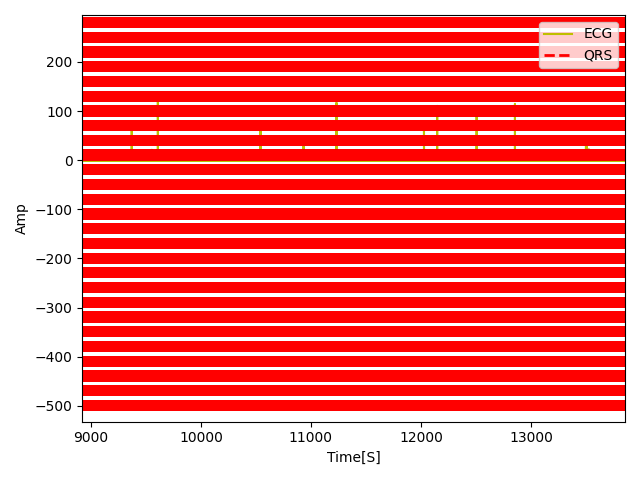

In [47]:
# Plots
fig = plt.figure(frameon="False") 
plt.plot(np.arange(ECG_ma.shape[0])/Fs,ECG_ma,color='y',label='ECG')
plt.vlines(x=(QRS-15)/Fs,ymin=np.min(ECG_raw),ymax=np.max(ECG_raw),,color='r', label='QRS',linewidth=2.0)
plt.ylabel('Amp'); plt.xlabel('Time[S]'); plt.legend()
plt.tight_layout(); plt.show()
# fig.savefig('QRS_pks.png', transparent=True)

In [6]:
from ecgdetectors import Detectors
detectors = Detectors(Fs)

In [8]:
r_peaks = detectors.pan_tompkins_detector(ECG)

In [24]:
ecg = df[0].to_numpy()
signals = np.zeros_like(ecg)
signals[QRS - 35] = 1

<IPython.core.display.Javascript object>


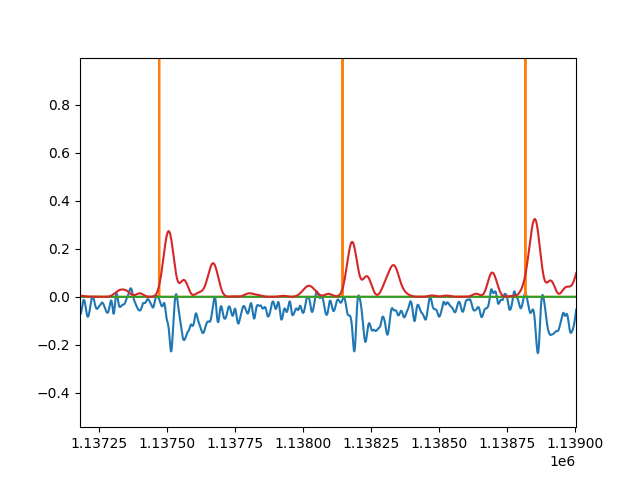

In [29]:
plt.plot(ecg)
plt.plot(signals)
plt.plot(df[1].to_numpy())
plt.plot(ECG_ma / 200)
plt.axis([0, 5_000, -0.5, 1])
plt.show()

In [30]:
np.mean(ECG_ma) / 200

0.10362211729144236